# AdvancedBMT Synthetic IIoT Data Generator 

>
> Apr 14, 2025 v0.0.1
>
>- Python 3.10


In [99]:
# ### run this cell for version check
# !python --version
# import pandas
# import matplotlib
# import sklearn
# print("Pandas version:", pandas.__version__)
# print("Matplotlib version:", matplotlib.__version__)
# print("Scikit-learn version:", sklearn.__version__)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [101]:
# CONFIG
train_file = "../test_csv/motor_no_anomoly.csv"
test_file = "../test_csv/motor_power_high.csv"
sensor_tag = "rpm"
sequence_length = 1000
batch_size = 64
epochs = 50
hidden_size = 128
model_path = f"best_model_{sensor_tag}.pt"
threshold_percentile = 95

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [102]:
# ==== Step 1: Load & Process Data ====

def load_and_prepare_data(file_path, seq_len=30, return_labels=False):
    df = pd.read_csv(file_path, parse_dates=["timestamp"])
    
    # Aggregate anomaly label across sensors per timestamp
    if return_labels:
        anomaly_map = (
            df.groupby("timestamp")["is_anomaly"]
            .apply(lambda x: int(any(str(val).lower() in ["true", "1", "yes"] for val in x)))
        )

    # Pivot sensor data
    df_pivot = df.pivot(index="timestamp", columns="sensor", values="feature_0")
    df_pivot = df_pivot.interpolate().dropna()

    # Scale
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_pivot)

    sequences = []
    labels = []

    for i in range(len(scaled_data) - seq_len):
        seq = scaled_data[i:i + seq_len]
        sequences.append(seq)
        
        if return_labels:
            label_ts = df_pivot.index[i + seq_len - 1]
            label_val = anomaly_map.get(label_ts, 0)
            labels.append(label_val)

    X = torch.tensor(sequences, dtype=torch.float32)
    if return_labels:
        return X, scaler, df_pivot.index[seq_len:], np.array(labels)
    else:
        return X, scaler, df_pivot.index[seq_len:]
# ==== Step 2: LSTM Autoencoder ====

class DeepLSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.decoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=input_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        _, (hidden, _) = self.encoder(x)  # hidden: (num_layers, batch, hidden_size)
        
        # Use the last layer’s hidden state for decoding
        h_last = hidden[-1].unsqueeze(1).repeat(1, x.size(1), 1)  # (batch, seq_len, hidden_size)
        
        decoded, _ = self.decoder(h_last)  # output: (batch, seq_len, input_size)
        return decoded

# ==== Step 3: Train the Model ====

def train_model(model, train_loader, num_epochs=20, lr=1e-3):
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        total_loss = 0
        for (batch,) in train_loader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

# ==== Step 4: Detect Anomalies ====

def detect_anomalies(model, test_tensor, threshold=None):
    model.eval()
    with torch.no_grad():
        test_tensor = test_tensor.to(device)
        reconstructed = model(test_tensor)
        loss_fn = nn.MSELoss(reduction='none')
        losses = loss_fn(reconstructed, test_tensor).mean(dim=(1, 2)).cpu().numpy()

        if threshold is None:
            threshold = np.percentile(losses, 95)

        is_anomaly = losses > threshold
        return losses, is_anomaly, threshold

In [103]:
# ==== Step 5: Main Pipeline ====

SEQ_LEN = 50
BATCH_SIZE = 64

# Load training data (no anomalies)
train_tensor, scaler, _ = load_and_prepare_data(train_file, SEQ_LEN)
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=BATCH_SIZE, shuffle=False)

# Model setup
input_size = train_tensor.shape[2]  # number of sensors
print(f"Input size: {input_size}")
print(f"input shape: {train_tensor.shape}")
model = DeepLSTMEncoder(
    input_size=train_tensor.shape[2],  # 4 sensors
    hidden_size=128,
    num_layers=3,
    dropout=0.4
).to(device)

# Train
train_model(model, train_loader)


Input size: 4
input shape: torch.Size([20096, 50, 4])
Epoch 1/20, Loss: 78.4218
Epoch 2/20, Loss: 36.0358
Epoch 3/20, Loss: 29.6043
Epoch 4/20, Loss: 28.8977
Epoch 5/20, Loss: 28.4061
Epoch 6/20, Loss: 28.0233
Epoch 7/20, Loss: 27.7720
Epoch 8/20, Loss: 27.5482
Epoch 9/20, Loss: 27.3657
Epoch 10/20, Loss: 27.2265
Epoch 11/20, Loss: 27.0983
Epoch 12/20, Loss: 27.0095
Epoch 13/20, Loss: 26.9269
Epoch 14/20, Loss: 26.8616
Epoch 15/20, Loss: 26.8106
Epoch 16/20, Loss: 25.5777
Epoch 17/20, Loss: 19.9156
Epoch 18/20, Loss: 25.6259
Epoch 19/20, Loss: 26.9429
Epoch 20/20, Loss: 26.9896


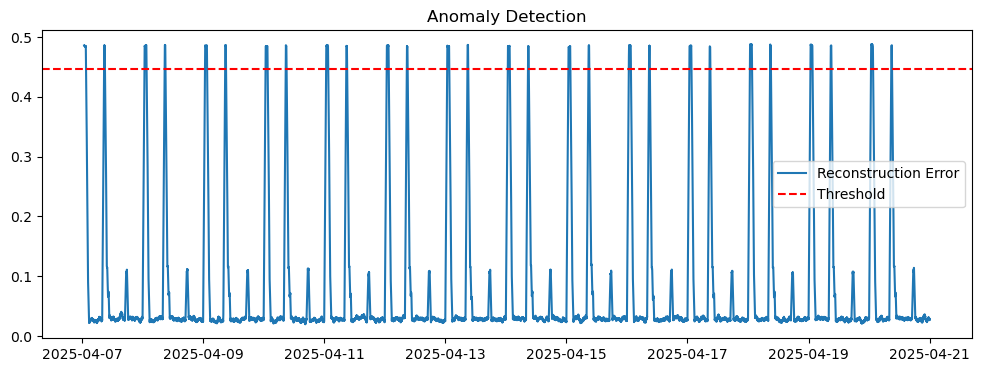

<Figure size 600x500 with 0 Axes>

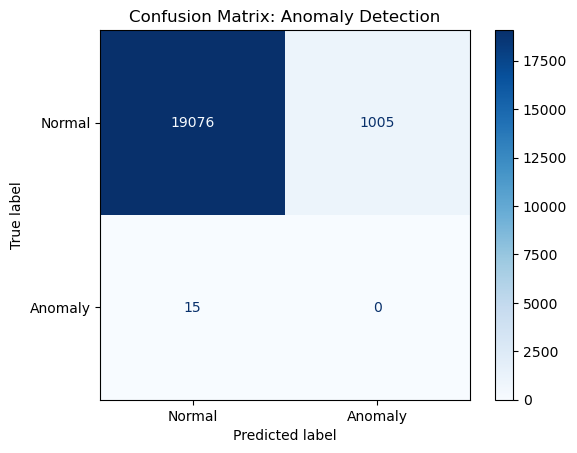

In [ ]:

# Load test data (with anomalies)
test_tensor, _, test_timestamps, y_true = load_and_prepare_data(test_file, seq_len=SEQ_LEN, return_labels=True)
losses, y_pred, threshold = detect_anomalies(model, test_tensor)

# Plot anomaly scores
plt.figure(figsize=(12,4))
plt.plot(test_timestamps, losses, label="Reconstruction Error")
plt.axhline(threshold, color='r', linestyle='--', label="Threshold")
plt.title("Anomaly Detection")
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert boolean to int if needed
y_pred = y_pred.astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])

# Plot
plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Anomaly Detection")
plt.show()